## Template Attack the first key byte

In [1]:
#5000 traces, pText, random keys
import numpy as np

tempPText = np.load("Traces\\AES_5000_varibale_key\\p.npy")
tempTraces = np.load("Traces\\AES_5000_varibale_key\\traces.npy")
tempKey = np.load("Traces\\AES_5000_varibale_key\\k.npy")


In [2]:
#The sbox is standard
sbox=(
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16) 

In [3]:
#attack point, we attack the first round of AES. The first round only do the following operations
tempSbox = [sbox[tempPText[i][0] ^ tempKey[i][0]] for i in range(len(tempPText))]

In [4]:
#calculating the huming weight of each number from 0~255, constructing a hash table tempHW for them
hw = [bin(x).count("1") for x in range(256)]
tempHW = [hw[s] for s in tempSbox]

In [5]:
#the statistic of HW value for each traces(0~8bit), like tempTracesHW[0] value means the number of the first round for how many 0 bit result. 
tempTracesHW = [[] for _ in range(9)]
for i in range(len(tempTraces)):
    HW = tempHW[i]
    tempTracesHW[HW].append(tempTraces[i])
tempTracesHW = [np.array(tempTracesHW[HW]) for HW in range(9)]

In [6]:
#we need calculate the means of 0~8bit traces
tempMeans = np.zeros((9, len(tempTraces[0])))
for i in range(9):
    tempMeans[i] = np.average(tempTracesHW[i], 0)

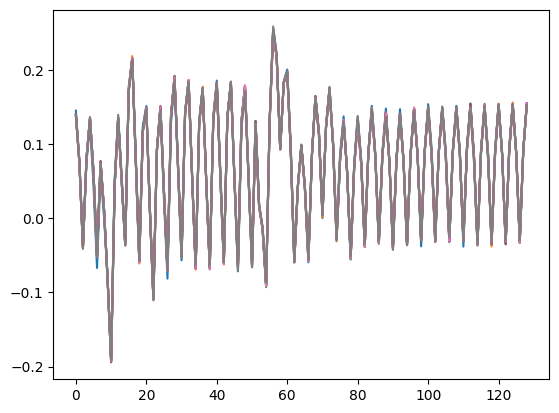

In [7]:
#we can look the picture to see the difference between 0~8 bit results, the average stratege has many interesting points
import matplotlib.pyplot as plt
for i in range(0,8):
    plt.plot(tempMeans[i])

In [8]:
#one interesting thing is that the result meets normal distribution
for i in range(0,9):
    print(str(i) + ":" + str(len(tempTracesHW[i])))


0:25
1:156
2:538
3:1116
4:1309
5:1086
6:588
7:166
8:16


In [9]:
tempSumDiff = np.zeros(len(tempTraces[0]))

In [10]:
for i in range(9):
    for j in range(i):
        tempSumDiff += np.abs(tempMeans[i] - tempMeans[j])

In [11]:
# Some settings that we can change
numPOIs = 5        # How many POIs do we want?
POIspacing = 5     # How far apart do the POIs have to be?

# Make an empty list of POIs
POIs = []

# Repeat until we have enough POIs
for i in range(numPOIs):
    # Find the biggest peak and add it to the list of POIs
    nextPOI = tempSumDiff.argmax()
    POIs.append(nextPOI)
    
    # Zero out some of the surrounding points
    # Make sure we don't go out of bounds
    poiMin = max(0, nextPOI - POIspacing)
    poiMax = min(nextPOI + POIspacing, len(tempSumDiff))
    for j in range(poiMin, poiMax):
        tempSumDiff[j] = 0

# Make sure they look okay
print(POIs)

[6, 47, 110, 88, 101]


In [12]:
meanMatrix = np.zeros((9, numPOIs))
for HW in range(9):
    for i in range(numPOIs):
        meanMatrix[HW][i] = tempMeans[HW][POIs[i]]

In [13]:
import numpy as np
def cov(x, y):
    # Find the covariance between two 1D lists (x and y).
    # Note that var(x) = cov(x, x)
    return np.cov(x, y)[0][1]

covMatrix  = np.zeros((9, numPOIs, numPOIs))
for HW in range(9):
    for i in range(numPOIs):
        for j in range(numPOIs):
            x = tempTracesHW[HW][:,POIs[i]]
            y = tempTracesHW[HW][:,POIs[j]]
            covMatrix[HW,i,j] = cov(x, y)

In [14]:
print(meanMatrix)
print(covMatrix[0])

[[-0.06700195  0.12001953 -0.03818359  0.1478418   0.09237305]
 [-0.05082351  0.12829903 -0.02692433  0.14254526  0.08285914]
 [-0.05137617  0.13184547 -0.03101312  0.14267841  0.08433243]
 [-0.05057627  0.13053385 -0.02846885  0.14185795  0.08377721]
 [-0.05258573  0.1293093  -0.02961506  0.14269563  0.0843048 ]
 [-0.0507862   0.1306249  -0.02904599  0.14206939  0.0840752 ]
 [-0.0523009   0.13010038 -0.02958378  0.14131964  0.08314275]
 [-0.0533462   0.12543828 -0.03165592  0.13673346  0.0856463 ]
 [-0.04039001  0.14237976 -0.01654053  0.15534973  0.07154846]]
[[ 4.56005732e-04  2.78094411e-04  1.58996880e-04  4.08221285e-05
  -1.95128322e-04]
 [ 2.78094411e-04  8.18674763e-04  3.40349972e-04  1.79549058e-05
  -2.89257367e-04]
 [ 1.58996880e-04  3.40349972e-04  2.78648237e-03  1.02345149e-04
  -2.29764481e-04]
 [ 4.08221285e-05  1.79549058e-05  1.02345149e-04  7.69719879e-04
  -9.37855244e-05]
 [-1.95128322e-04 -2.89257367e-04 -2.29764481e-04 -9.37855244e-05
   7.66927401e-04]]


In [15]:
# This is attack traces
atkTraces = np.load("Traces\\AES_5000_fixed_key\\traces.npy")
atkPText = np.load("Traces\\AES_5000_fixed_key\\p.npy")
atkKey = np.load("Traces\\AES_5000_fixed_key\\k.npy")

    

In [16]:
#record the possibility of each result value
P_k = np.zeros(256)

In [17]:
from scipy.stats import multivariate_normal

In [18]:
#attack for the first byte just using 5 traces
for j in range(5):
    # Grab key points and put them in a matrix
    a = [atkTraces[j][POIs[i]] for i in range(len(POIs))]
    
    # Test each key
    for k in range(256):
        # Find HW coming out of sbox
        HW = hw[sbox[atkPText[j][0] ^ k]]
    
        # Find p_{k,j}
        rv = multivariate_normal(meanMatrix[HW], covMatrix[HW])
        p_kj = rv.pdf(a)
   
        # Add it to running total
        P_k[k] += np.log(p_kj)

    # Print our top 5 results so far
    # Best match on the right
    print(P_k.argsort()[-5:])

[229 230 201 127  43]
[229 122 230  43  71]
[ 35  43 201  89  71]
[ 35  89 201 182  71]
[ 43 251 201 182  71]


In [19]:
#The above result shows 43 almost in each rows, so the first byte are successfully been attacked
print("real key:")
print(atkKey[0])

real key:
[ 43 126  21  22  40 174 210 166 171 247  21 136   9 207  79  60]
